# RAG (Retrieval-Augmented Generation) with LangChain

This notebook demonstrates how to build a complete RAG pipeline using LangChain and Azure OpenAI. RAG enhances language model responses by retrieving relevant context from a knowledge base before generating answers.

## Overview
We'll cover the following steps:
1. **Environment Setup**: Load API credentials
2. **Initialize Embeddings**: Create an embedding model for converting text to vectors
3. **Initialize LLM**: Set up the language model for generating responses
4. **Create Vector Store**: Initialize an in-memory vector database
5. **Load Documents**: Fetch and parse web content
6. **Split Documents**: Break large documents into smaller chunks
7. **Store Embeddings**: Add document chunks to the vector store
8. **Create RAG Chain**: Build a retrieval-augmented generation workflow
9. **Test the System**: Query the RAG system

## Step 1: Environment Setup and API Key Management

This section handles the secure loading of API credentials:
- **`load_dotenv()`**: Loads environment variables from a `.env` file if it exists in the project directory
- **Security Best Practice**: Checks if the API key is already set in environment variables before prompting
- **Interactive Prompt**: If the key isn't found, securely prompts the user to enter it (input will be hidden)
- This approach works both in local development (with `.env` file) and in production (with system environment variables)

In [1]:
from dotenv import load_dotenv
import getpass
import os

# Load environment variables from a .env file if present. This helps in local dev where env vars aren't set.
load_dotenv()

# Prompt for API key only if not present in environment variables after loading .env
if not os.environ.get("AZURE_OPENAI_API_KEY"):
    os.environ["AZURE_OPENAI_API_KEY"] = getpass.getpass("Enter your Azure OpenAI API key: ")

## Step 2: Initialize the Embedding Model

**Embeddings** convert text into numerical vectors (arrays of numbers) that capture semantic meaning.

### What's happening here:
- **`AzureOpenAIEmbeddings`**: Creates an embeddings client connected to Azure OpenAI
- **`text-embedding-ada-002`**: A powerful embedding model that converts text to 1536-dimensional vectors
- **Purpose**: These embeddings will be used to:
  1. Convert document chunks into vectors for storage
  2. Convert user questions into vectors for similarity search
  
### Why embeddings matter in RAG:
Similar concepts will have similar vector representations, allowing us to find relevant documents by comparing vector similarity rather than exact keyword matches.

In [2]:
from langchain_openai import AzureOpenAIEmbeddings

embeddings = AzureOpenAIEmbeddings(
    azure_endpoint="https://aoi-ext-eus-aiml-profx-01.openai.azure.com/",
    api_key=os.environ["AZURE_OPENAI_API_KEY"],
    model="text-embedding-ada-002",
    api_version="2024-12-01-preview"
)

## Step 3: Initialize the Language Model (LLM)

**Large Language Models (LLMs)** generate human-like text responses based on input prompts.

### Configuration:
- **`AzureChatOpenAI`**: Creates a chat-optimized LLM client
- **`gpt-4o`**: The model deployment name (GPT-4 Optimized version)
- **API Version**: Specifies the Azure OpenAI API version for compatibility

### Role in RAG:
The LLM will generate the final answer by:
1. Receiving the user's question
2. Receiving relevant context retrieved from the vector store
3. Synthesizing a response that combines both

In [3]:
from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(
    azure_endpoint="https://aoi-ext-eus-aiml-profx-01.openai.azure.com/",
    api_key=os.environ["AZURE_OPENAI_API_KEY"],
    model="gpt-4o",
    api_version="2024-12-01-preview"
)

## Step 4: Create the Vector Store

**Vector Stores** (or Vector Databases) store document embeddings and enable fast similarity searches.

### What is `InMemoryVectorStore`?
- Stores vectors in RAM (not persisted to disk)
- Fast for development and small datasets
- Automatically uses the embeddings model we configured earlier

### How it works:
1. Documents are converted to embeddings using our embedding model
2. Embeddings are stored along with the original text
3. When queried, it finds the most similar vectors using cosine similarity or other distance metrics

**Note**: For production use with large datasets, consider persistent vector stores like Chroma, Pinecone, or Azure AI Search.

In [4]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

## Step 5: Load Documents from the Web

**Document Loading** is the first step in building a knowledge base for RAG.

### Components:
- **`WebBaseLoader`**: Fetches HTML content from web URLs
- **`bs4.SoupStrainer`**: Filters HTML to keep only relevant content (removes navigation, footers, etc.)
- **Target**: A blog post about AI agents from Lilian Weng's blog

### The Process:
1. **Fetch**: Download the HTML from the specified URL
2. **Parse**: Use BeautifulSoup to extract only the content sections
3. **Load**: Convert to LangChain document format

### Why filter HTML?
- Reduces noise (ads, navigation, comments)
- Focuses on the main content
- Improves embedding quality and retrieval accuracy

**Result**: A single document containing the full blog post content.

In [8]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

Total characters: 43047


## Step 6: Preview the Document Content

Let's inspect the first 500 characters of the loaded document to verify the content was extracted correctly.

In [9]:
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


## Step 7: Split Documents into Chunks

**Why split documents?**
- LLMs have context window limits (maximum input size)
- Smaller chunks create more precise embeddings
- Retrieval can target specific relevant sections instead of entire documents

### Text Splitting Strategy:
- **`chunk_size=1000`**: Each chunk is approximately 1000 characters
- **`chunk_overlap=200`**: Consecutive chunks share 200 characters to maintain context continuity
- **`add_start_index=True`**: Tracks where each chunk originated in the source document

### The RecursiveCharacterTextSplitter:
- Tries to split on natural boundaries (paragraphs, sentences, words)
- Falls back to character-level splitting if needed
- Preserves semantic coherence within chunks

**Result**: The single large document is split into multiple smaller, manageable chunks.

In [10]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 63 sub-documents.


## Step 8: Add Documents to Vector Store

**Indexing** the documents by converting them to embeddings and storing them.

### What happens in `add_documents()`:
1. Each document chunk is sent to the embedding model
2. The embedding model returns a vector (array of numbers) for each chunk
3. The vector store saves both the embedding and the original text
4. Returns unique IDs for each stored document

### The Magic:
- Documents with similar semantic meaning will have similar embedding vectors
- When we later search with a question, the vector store can find chunks with similar embeddings
- This enables **semantic search** (meaning-based) rather than keyword matching

**Output**: A list of document IDs confirming successful storage.

In [11]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['a361d3ea-5100-4367-a7bb-1138cc2149b8', 'f611aa8d-592f-4743-b2bd-17a844d7f3c9', 'df610398-ece3-43d3-b5c6-a3f830a97373']


## Step 9: Load the RAG Prompt Template

**Prompt Engineering** is crucial for effective RAG systems.

### What is `hub.pull()`?
- Loads a pre-built prompt template from LangChain Hub (a repository of community prompts)
- **`"rlm/rag-prompt"`**: A well-tested RAG prompt template

### The RAG Prompt Structure:
The template instructs the LLM to:
1. Use the provided context to answer the question
2. Say "I don't know" if the context doesn't contain the answer
3. Keep answers concise and grounded in the context

### Why use a template?
- Consistent response quality
- Reduces hallucinations (making up information)
- Ensures the LLM leverages the retrieved context effectively

**Preview**: We can see how the template formats the context and question.

In [12]:
from langchain import hub

# N.B. for non-US LangSmith endpoints, you may need to specify
# api_url="https://api.smith.langchain.com" in hub.pull.
prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


## Step 10: Define the State Schema

**State Management** for our RAG workflow using TypedDict.

### What is State?
A structured data container that flows through our RAG pipeline:
- **`question`**: The user's input query (str)
- **`context`**: Retrieved documents relevant to the question (List[Document])
- **`answer`**: The LLM's generated response (str)

### Why define State?
- **Type Safety**: Ensures each step receives and returns the correct data types
- **Clarity**: Makes the data flow explicit and easier to debug
- **LangGraph Integration**: LangGraph uses this schema to manage state between nodes

This will be used in the next steps to build a stateful workflow graph.

In [13]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

## Step 11: Define RAG Workflow Functions

**The two core functions of the RAG pipeline:**

### 1. `retrieve(state)` - Retrieval Step
- **Input**: Takes the current state (containing the question)
- **Process**: 
  - Converts the question to an embedding
  - Searches the vector store for similar document chunks
  - Uses cosine similarity to find the most relevant documents
- **Output**: Updates state with `context` (list of retrieved documents)

### 2. `generate(state)` - Generation Step
- **Input**: Takes the state (containing question and context)
- **Process**:
  - Combines all retrieved document content into a single string
  - Formats the prompt with the question and context
  - Sends to the LLM for answer generation
- **Output**: Updates state with `answer` (the LLM's response)

### The RAG Flow:
**Question → Retrieve Context → Generate Answer**

In [14]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

## Step 12: Build the RAG Graph with LangGraph

**LangGraph** creates a stateful, directed workflow for our RAG pipeline.

### Graph Construction:
1. **`StateGraph(State)`**: Initialize a graph that manages our State schema
2. **`add_sequence([retrieve, generate])`**: Chain the functions sequentially
   - First: `retrieve` gets relevant documents
   - Then: `generate` creates the answer
3. **`add_edge(START, "retrieve")`**: Define the entry point (start with retrieval)
4. **`compile()`**: Build the executable graph

### Benefits of LangGraph:
- **State Persistence**: Automatically passes state between nodes
- **Debugging**: Can visualize and trace the workflow
- **Flexibility**: Easy to add steps (e.g., query rewriting, re-ranking)
- **Streaming**: Can stream intermediate results

**Result**: A compiled graph ready to process questions through the RAG pipeline.

In [15]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

## Step 13: Visualize the Workflow Graph

**Visual Representation** of our RAG pipeline using Mermaid diagrams.

### What to Expect:
The diagram will show:
- **Nodes**: Each step in the workflow (`retrieve`, `generate`)
- **Edges**: The flow of data between steps
- **Entry Point**: Where the workflow starts
- **End Point**: Where it completes

This visualization helps understand the execution flow and is useful for:
- Debugging complex workflows
- Documentation and team communication
- Identifying optimization opportunities

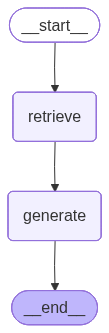

In [16]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## Step 14: Test the RAG System

**First Query** - Testing the complete pipeline with a sample question.

### Execution Flow:
1. **Input**: `{"question": "What is Task Decomposition?"}`
2. **Retrieve Step**: 
   - Converts question to embedding
   - Finds most similar document chunks from the blog post
   - Returns relevant context about task decomposition
3. **Generate Step**:
   - Formats prompt with question + retrieved context
   - LLM generates answer based on the context
4. **Output**: Complete result with context and answer

### Expected Result:
- **Context**: The actual document chunks retrieved from the vector store
- **Answer**: A concise explanation of Task Decomposition based on the blog content

In [17]:
result = graph.invoke({"question": "What is Task Decomposition?"})

print(f"Context: {result['context']}\n\n")
print(f"Answer: {result['answer']}")

Context: [Document(id='df610398-ece3-43d3-b5c6-a3f830a97373', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1638}, page_content='Component One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.\nTree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth

## Step 15: Stream the Workflow Updates

**Streaming Mode: Updates** - Observe each step of the workflow as it executes.

### What is `stream_mode="updates"`?
- Shows the state changes after each node completes
- Provides visibility into the pipeline execution
- Useful for debugging and understanding the workflow

### Output Format:
You'll see two updates:
1. **After `retrieve`**: Shows the retrieved context documents
2. **After `generate`**: Shows the generated answer

This is helpful for:
- **Debugging**: Identify which step is slow or failing
- **Validation**: Verify the right documents are being retrieved
- **Monitoring**: Track progress in real-time applications

In [18]:
for step in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='df610398-ece3-43d3-b5c6-a3f830a97373', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1638}, page_content='Component One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.\nTree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can

## Step 16: Stream LLM Messages (Token-by-Token)

**Streaming Mode: Messages** - Watch the LLM generate the response in real-time.

### What is `stream_mode="messages"`?
- Streams individual messages/tokens as they're generated by the LLM
- Shows the answer being constructed incrementally
- Similar to how ChatGPT displays responses word-by-word

### Use Cases:
- **User Experience**: Display progressive responses in chat interfaces
- **Real-time Feedback**: Users see that processing is happening
- **Early Termination**: Can stop generation if the answer is sufficient

### Output:
- Each token/chunk of the LLM response is printed as it's generated
- The `|` separator shows where each chunk ends
- This demonstrates the streaming capability for production applications

In [19]:
for message, metadata in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="messages"
):
    print(message.content, end="|")

||Task| decomposition| involves| breaking| down| complex| tasks| into| smaller|,| simpler|,| and| manageable| subt|asks|.| Techniques| like| Chain| of| Thought| (|Co|T|)| and| Tree| of| Thoughts| (|To|T|)| enhance| this| process| by| encouraging| step|-by|-step| reasoning| or| exploring| multiple| possibilities|.| De|composition| can| be| done| with| L|LM| prompts|,| human| inputs|,| task|-specific| instructions|,| or| external| planning| tools| like| P|DDL| for| detailed| planning|.|||